In [1]:
import os
os.chdir("../../..")
import jax
jax.devices()

[CpuDevice(id=0)]

In [ ]:
from scripts.nj.neurosci import *
import scripts.nj.graph_to_arrays as ga

d:\Iliuha_projects\neurosci\bbab\Drosophila-Larvae-Simulation\.venv_jax\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Получаем данные

In [ ]:
res = ga.load_jax_context("Datasets/Generated/jax/2025d5/test_graph_20n.npz")

Загрузка контекста из: Datasets/Generated/jax/2025d5/test_graph_20n.npz
   Загружено: 2 групп, 3 массивов ребер, 0 массивов признаков.
Контекст симуляции успешно собран из загруженных данных.


In [4]:
stom = jnp.array(res['stom'])

## Определяем структуру симуляции

In [5]:
ind_to_stim = stom[0][1]
def get_my_pipeline(constants, dt = 0.1):

    cable_m = res['edges_cable_to_cable'].T
    pre_syn = res['edges_cable_to_alpha'].T
    post_syn = res['edges_cable_to_alpha'].T
    
    r = jnp.array(res['r'])
    x = jnp.array(res['x'])
    y = jnp.array(res['y'])
    z = jnp.array(res['z'])
    S = np.pi * r**2

    dx = x.at[cable_m[:, 1]].get() - x.at[cable_m[:, 0]].get()
    dy = y.at[cable_m[:, 1]].get() - y.at[cable_m[:, 0]].get()
    dz = z.at[cable_m[:, 1]].get() - z.at[cable_m[:, 0]].get()

    L = (dx**2 + dy**2 + dz**2)**0.5
    ro = 1.0 # по идеи должно быть 100, но потом разберемся
    R = (ro*L/S.at[cable_m[:, 1]].get())
    

    HH = get_HH_pipeline(**constants) # получаем функцию для HH
    cable = laplace_at_graph_symetric(cable_m, 'V')#, scaling = R) # получаем функцию для динамики кабелей
    alphaP = get_alpha_synapce_pipeline(pre_syn, post_syn, **constants)
    
    @jax.jit
    def state_transformed(state):
        s, ds = to_diff(state) # создает ds той же формы что и state, но заполненный нулями
        s, ds = alphaP(s, ds)
        s, ds = HH(s, ds) # вставляет HH каналы
        s, ds = cable(s, ds) # соединяет сегменты
        ds['V'] += ds['V'].at[ind_to_stim].add(100.0)
        return s, ds

    integrate = get_runge_kutta_step(state_transformed, dt) # получаем функцию для интегрирования
    @jax.jit
    def my_pipeline(state):
        s = integrate(state) # интегрируем
        return s
    return my_pipeline


### Начальные значения и константы


In [6]:
num_nodes_hh = res['num_nodes']['cable']
num_synapces = res['num_nodes']['alpha']
total_nodes = num_nodes_hh + num_synapces

initials = {
    "V":jnp.ones((num_nodes_hh, ), jnp.float32)*-65.0,
    "m":jnp.ones((num_nodes_hh, ), jnp.float32)*0.0220,
    'n':jnp.ones((num_nodes_hh, ), jnp.float32)*0.0773,
    'h':jnp.ones((num_nodes_hh, ), jnp.float32)*0.9840,
    'alpha':jnp.ones((num_nodes_hh, 2), jnp.float32)*0.1,
    "time":0.0
}

consts = {
    "C": jnp.ones((num_nodes_hh, ), jnp.float32),# Емкость мембраны (мкФ/см^2)
    "ENa": 50.0,   # Равновесный потенциал Na+ (мВ)
    "EK": -77.0,   # Равновесный потенциал K+ (мВ)
    "EL": -54.4,   # Равновесный потенциал утечки (мВ)
    "gNa": 120.0,  # Максимальная проводимость Na+ (мСм/см^2)
    "gK": 36.0,    # Максимальная проводимость K+ (мСм/см^2)
    "gL": 0.3,     # Проводимость утечки (мСм/см^2),
    "tau":1.0,
    'E_rev':1.0,
    'V_m':jnp.ones((num_nodes_hh, ), jnp.float32),
    'alpha_syn_detector_treshold':40.0,
    'synaptic_weights':0.01,
    'G_max':1.0
}


new_consts = {
    "C": jnp.ones((num_nodes_hh, ), jnp.float32),# Емкость мембраны (мкФ/см^2)
    "ENa": 50.0,   # Равновесный потенциал Na+ (мВ)
    "EK": -77.0,   # Равновесный потенциал K+ (мВ)
    "EL": -54.4,   # Равновесный потенциал утечки (мВ)
    "gNa": 0.12,  # Максимальная проводимость Na+ (мСм/см^2)
    "gK": 0.036,    # Максимальная проводимость K+ (мСм/см^2)
    "gL": 0.0003,     # Проводимость утечки (мСм/см^2),
    "tau":0.5,
    'E_rev':0.0,
    'V_m':jnp.ones((num_nodes_hh, ), jnp.float32),
    'alpha_syn_detector_treshold':0.5,
    'synaptic_weights':0.5,
    'G_max':1.0
}

In [7]:
my_pipeline = get_my_pipeline(consts, 0.1)

In [8]:
res.keys()

dict_keys(['num_nodes', 'mapping', 'edges_cable_to_cable', 'edges_cable_to_alpha', 'edges_alpha_to_cable', 'stom', 'x', 'y', 'z', 'r', '__RAW_GLOBAL_MAPPING__', '__RAW_LOCAL_MAPS__'])

## Запуск симуляции

In [ ]:
@jax.jit
def output_transform(state):
    return state['time'], state['V'].at[stom[:, 1]].get()

jsim = simulation(initials, my_pipeline, 100, output_transform)
H = jsim.run(100)

## Построение графиков

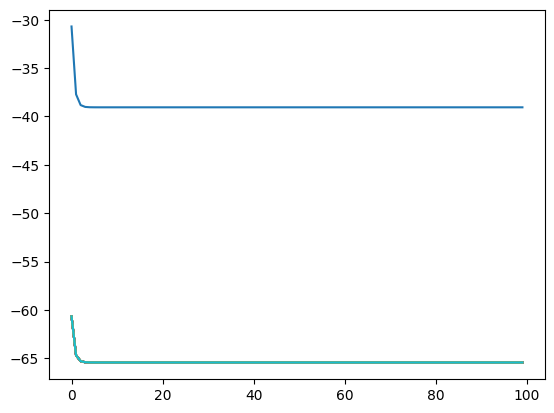

In [10]:
import matplotlib.pyplot as plt
t, v = H
t, v = np.array(t), np.array(v)
plt.plot(v)
plt.show()